# Аналіз Баєсівських Мереж: Від Пошуку Шляхів до Оптимізації Зв'язків

## Попередні налаштування: підготовка середовища та визначення функцій

### Імпорт всіх необхідних бібліотек

In [14]:
# Імпорт бібліотек для роботи з графами, візуалізацією та ймовірнісним аналізом.
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
import numpy as np
from collections import deque
import heapq
from typing import List, Tuple, Dict, Optional, Iterable, Any, Set
import pandas as pd
from IPython.display import display, Markdown
import time

# Додано pgmpy для визначення Баєсівської мережі та обчислень ймовірностей.
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.factors.discrete import TabularCPD, DiscreteFactor
from pgmpy.inference import VariableElimination

# Маленька константа для зсуву ваг, якщо взаємна інформація дорівнює 0
EPSILON = 1e-9

### DFS (Пошук у глибину)
Очікувана складність: O(V+E), де V - кількість вершин, E - кількість ребер.

In [2]:
def dfs_iterative(G: nx.DiGraph, src: str, dst: str) -> Optional[List[str]]:
    """Повертає шлях, знайдений за допомогою пошуку в глибину (стек LIFO).
    Зупиняється на першому входженні *dst*; не обов'язково найкоротшому.
    Реалізовано без рекурсії, щоб уникнути переповнення стеку на великих графах.
    
    Args:
        G: Орієнтований граф networkX.
        src: Початкова вершина.
        dst: Кінцева вершина.
    
    Returns:
        Список вершин у шляху, або None, якщо шлях не знайдено.
    """
    if src not in G or dst not in G:
        # Або можна повернути None або викликати помилку, залежно від бажаної поведінки
        # raise KeyError("Both src and dst must exist in the graph.") 
        return None
    if src == dst:
        return [src]

    stack: List[Tuple[str, List[str]]] = [(src, [src])]
    visited: Set[str] = set()

    while stack:
        node, path = stack.pop()
        if node == dst:
            return path
        # Відвідуємо вузол лише якщо він ще не був у поточному шляху розширення стеку DFS
        # Для загального DFS по графу, visited додається тут. 
        # Для пошуку шляху, іноді visited перевіряється/додається інакше, щоб дозволити 
        # знаходити шляхи, навіть якщо вузли були відвідані через іншу гілку.
        # У даній реалізації, якщо вузол вже був оброблений (знятий зі стеку), 
        # ми його більше не розглядаємо.
        if node in visited:
            continue
        visited.add(node)
        
        # Додаємо сусідів у стек у зворотному порядку, щоб обхід був більш "природнім"
        # або відповідати рекурсивному порядку.
        for neigh in reversed(list(G.successors(node))): 
            # Не додаємо в стек, якщо сусід вже був повністю оброблений.
            # Для простого пошуку шляху ця перевірка visited не завжди потрібна тут,
            # її можна робити при витяганні зі стеку. Однак це може зменшити розмір стеку.
            if neigh not in visited: 
                stack.append((neigh, path + [neigh]))
    return None # Шлях не знайдено

### BFS (Пошук у ширину)
Очікувана складність: O(V+E), де V - кількість вершин, E - кількість ребер.

In [3]:
def bfs_iterative(G: nx.DiGraph, src: str, dst: str) -> Optional[List[str]]:
    """Повертає *найкоротший* шлях за кількістю ребер з використанням BFS (черга FIFO).
    
    Args:
        G: Орієнтований граф networkX.
        src: Початкова вершина.
        dst: Кінцева вершина.
    
    Returns:
        Список вершин у найкоротшому шляху, або None, якщо шлях не знайдено.
    """
    if src not in G or dst not in G:
        # raise KeyError("Both src and dst must exist in the graph.")
        return None
    if src == dst:
        return [src]

    queue: deque[Tuple[str, List[str]]] = deque([(src, [src])])
    # visited зберігає вузли, які вже були додані до черги, щоб уникнути циклів та повторної обробки
    visited: Set[str] = {src} 

    while queue:
        node, path = queue.popleft()
        # Примітка: dst перевіряється тут, а не при додаванні, щоб повернути повний шлях.
        # Якщо dst знайдено, це гарантовано найкоротший шлях, оскільки BFS досліджує по рівнях.
        
        # Перебираємо сусідів поточного вузла
        for neigh in G.successors(node):
            if neigh == dst:
                return path + [neigh] # Знайдено шлях до dst
            if neigh not in visited:
                visited.add(neigh)
                queue.append((neigh, path + [neigh]))
    return None # Шлях не знайдено

### Алгоритм Дейкстри
Очікувана складність: O((E+V) log V) з використанням бінарної купи, або O(E log V), якщо E > V.

In [4]:
def dijkstra_heap(G: nx.DiGraph, src: str, dst: str, weight: str = "weight") -> Tuple[Optional[List[str]], float]:
    """Знаходить найкоротший шлях за сумарною *вагою* з використанням алгоритму Дейкстри та бінарної купи.
    Повертає кортеж зі шляху (список вершин) та його ваги.
    Використовує `heapq` для оптимізації пошуку мінімального елемента.
    
    Args:
        G: Орієнтований граф networkX.
        src: Початкова вершина.
        dst: Кінцева вершина.
        weight: Назва атрибуту ребра, що містить вагу.
    
    Returns:
        Кортеж (шлях, вага_шляху). Якщо шлях не знайдено, повертає (None, float('inf')).
    """
    if src not in G or dst not in G:
        # raise KeyError(f"Node {src if src not in G else dst} not in graph.")
        return None, float("inf")
    if src == dst:
        return [src], 0.0

    # Ініціалізуємо відстані та попередників
    dist: Dict[str, float] = {node: float("inf") for node in G.nodes}
    prev: Dict[str, Optional[str]] = {node: None for node in G.nodes}

    dist[src] = 0.0
    # heapq працює як мін-купа: (поточна_відстань, вузол)
    pq: List[Tuple[float, str]] = [(0.0, src)] 

    while pq:
        d, node = heapq.heappop(pq) # Використовуємо heapq.heappop
        
        if node == dst:
            break # Знайдено найкоротший шлях до dst
            
        if d > dist[node]:
            continue  # Пропускаємо, якщо знайдено кращий шлях раніше (застарілий запис у купі)
            
        for neigh in G.successors(node):
            # Отримуємо вагу, по дефолту 1.0 якщо не вказана або None
            # EPSILON додається, якщо вага 0, але MI не повинна бути <0
            # Якщо weight атрибут гарантовано існує і > 0, то get(weight, 1.0) можна спростити
            edge_data = G.get_edge_data(node, neigh)
            w = 1.0 # Значення за замовчуванням
            if edge_data is not None and weight in edge_data:
                w_val = edge_data[weight]
                if w_val is not None:
                    w = float(w_val)
            
            # Гарантуємо позитивність ваг для алгоритму Дейкстри, якщо MI=0
            # (Хоча Дейкстра працює з нульовими вагами, іноді вимагають строго позитивні)
            # MI >= 0. Якщо MI=0, додаємо EPSILON
            # Цей зсув не потрібен для коректності Дейкстри, але виконано за запитом.
            current_edge_weight = w + EPSILON if w == 0 else w
            if current_edge_weight < 0:
                # Алгоритм Дейкстри не працює з від'ємними вагами
                # В даному випадку MI не може бути від'ємною.
                # Якщо б ваги могли бути від'ємними, треба було б використовувати Bellman-Ford або SPFA.
                pass # Або викликати помилку

            nd = d + current_edge_weight
            if nd < dist[neigh]:
                dist[neigh] = nd
                prev[neigh] = node
                heapq.heappush(pq, (nd, neigh)) # Використовуємо heapq.heappush

    # Якщо шлях до dst не знайдено
    if dist[dst] == float("inf"):
        # raise nx.NetworkXNoPath(f"No path from {src!r} to {dst!r} using Dijkstra.")
        return None, float("inf")

    # Відновлюємо шлях
    path_list: List[str] = []
    curr: Optional[str] = dst
    while curr is not None:
        path_list.append(curr)
        curr = prev[curr]
    
    return list(reversed(path_list)), dist[dst]

### Візуалізація

In [6]:
def plot_graph_custom(G: nx.DiGraph, 
                        highlighted_path: Optional[Iterable[str]] = None, 
                        *, 
                        title: str = "Bayesian Network Graph", 
                        ax: Optional[plt.Axes] = None, 
                        pos: Optional[Dict[str, Any]] = None, 
                        node_labels_viz: Optional[Dict[str, str]] = None, 
                        edge_labels_attr: Optional[str] = None,
                        show_all_edge_labels: bool = False) -> Dict[str, Any]:
    """Побудова графіку, використовуючи вказаний макет або макет пружини (spring layout).
    Вузол та ребра виділеного шляху підсвічуються.
    
    Args:
        G: Граф networkX.
        highlighted_path: Ітерабельний об'єкт (наприклад, список) з вузлами шляху для підсвічування.
        title: Заголовок графіку.
        ax: Об'єкт matplotlib.axes.Axes для малювання (якщо None, створюється новий).
        pos: Словник з позиціями вузлів. Якщо None, використовується spring_layout.
        node_labels_viz: Словник міток вузлів для візуалізації.
        edge_labels_attr: Атрибут ребер для відображення як міток (наприклад, 'weight').
        show_all_edge_labels: Якщо True, показує мітки для всіх ребер. 
                              Якщо False (за замовчуванням), показує мітки тільки для ребер виділеного шляху.
                              
    Returns:
        Словник позицій вузлів, що використовувався для побудови.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 9))

    current_pos = pos if pos is not None else nx.spring_layout(G, seed=42, k=0.9)
    labels_to_draw = node_labels_viz if node_labels_viz else {node: node for node in G.nodes()}
    
    # Малювання всіх вузлів та ребер
    nx.draw_networkx_nodes(G, current_pos, ax=ax, node_size=3000, node_color="lightblue", alpha=0.8)
    nx.draw_networkx_labels(G, current_pos, labels=labels_to_draw, font_size=8, font_weight="bold", ax=ax)
    nx.draw_networkx_edges(G, current_pos, ax=ax, width=1.5, alpha=0.5, arrows=True, arrowstyle='-|>', arrowsize=20)

    path_edge_list = []
    if highlighted_path:
        path_nodes = list(highlighted_path)
        if len(path_nodes) > 1:
            path_edge_list = list(zip(path_nodes[:-1], path_nodes[1:]))
            nx.draw_networkx_nodes(G, current_pos, nodelist=path_nodes, node_color='gold', node_size=3500, ax=ax, alpha=1.0)
            nx.draw_networkx_edges(G, current_pos, edgelist=path_edge_list, edge_color='red', width=2.5, ax=ax, arrows=True, arrowstyle='-|>', arrowsize=20, alpha=1.0)
        elif len(path_nodes) == 1: # Якщо шлях складається з одного вузла
             nx.draw_networkx_nodes(G, current_pos, nodelist=path_nodes, node_color='gold', node_size=3500, ax=ax, alpha=1.0)

    # Малювання міток ребер
    if edge_labels_attr:
        edge_labels_all = nx.get_edge_attributes(G, edge_labels_attr)
        # Форматуємо ваги до 2 знаків після коми
        formatted_edge_labels = {k: f"{v:.2f}" for k, v in edge_labels_all.items()}
        
        if show_all_edge_labels:
            edges_to_label = formatted_edge_labels
        elif path_edge_list: # Показувати мітки тільки для виділеного шляху
            edges_to_label = {edge: formatted_edge_labels[edge] for edge in path_edge_list if edge in formatted_edge_labels}
        else:
            edges_to_label = {} # Немає шляху, або не треба показувати мітки
            
        nx.draw_networkx_edge_labels(G, current_pos, edge_labels=edges_to_label, font_color='darkgreen', font_size=7, ax=ax)

    ax.set_title(title, fontsize=14)
    ax.axis("off")
    plt.tight_layout()
    return dict(current_pos) # Повертаємо позиції для можливого перевикористання

## Розділ 1: Вступ – Моделювання Баєсівської мережі

### 1.1. Баєсівські мережі як графи
Баєсівські мережі є потужним інструментом для моделювання складних систем із невизначеністю. Вони представляють набір випадкових змінних та їх умовні залежності у вигляді орієнтованого ациклічного графа (DAG). Вузли графа відповідають змінним, а ребра вказують на причинно-наслідкові зв'язки між ними. Це дозволяє моделювати ймовірнісні залежності та виконувати висновки на основі доступних даних.

### 1.2. Приклад: Модель діагностики захворювання
Для демонстрації графових алгоритмів у контексті Баєсівських мереж ми розглянемо розширену модель діагностики двох захворювань. Вузли представлятимуть фактори ризику, захворювання, симптоми та результати тестів, а ребра – їхні взаємозв'язки.

- **Вузли (змінні):**
   - 'R1': Куріння
   - 'R2': Генетична схильність
   - 'R3': Дієта
   - 'R4': Фізична активність
   - 'D1': Серцеве захворювання
   - 'D2': Діабет
   - 'S1': Біль у грудях
   - 'S2': Задишка
   - 'S3': Втома
   - 'S4': Підвищена спрага
   - 'S5': Часте сечовипускання
   - 'T1': ЕКГ
   - 'T2': Тест на цукор
   - 'T3': Тест на холестерин

- **Ребра (залежності):**
   - Від 'R1', 'R2', 'R3', 'R4' до 'D1'
   - Від 'R2', 'R3', 'R4' до 'D2'
   - Від 'D1' до 'S1', 'S2', 'S3', 'T1', 'T3'
   - Від 'D2' до 'S4', 'S5', 'T2'
   - Від 'S1' до 'T1', від 'S4' до 'T2'

### 1.3. Мета: Дослідження зв'язків у мережі
Ми побудуємо орієнтований граф, що моделює цю Баєсівську мережу, та проаналізуємо його структуру. Далі ми застосуємо алгоритми DFS, BFS та Дейкстри для пошуку шляхів між вузлами, що дозволить нам дослідити, як інформація (або вплив) може поширюватися через мережу.

## Розділ 2: Побудова та аналіз Баєсівської мережі

### 2.1. Визначення графа Баєсівської мережі

In [7]:
# Визначення Баєсівської мережі
bayesian_graph = nx.DiGraph()

# Додавання вузлів (змінних)
nodes_data = {
    'R1': {'label': 'Куріння'},
    'R2': {'label': 'Генетична схильність'},
    'R3': {'label': 'Дієта'},
    'R4': {'label': 'Фізична активність'},
    'D1': {'label': 'Серцеве захворювання'},
    'D2': {'label': 'Діабет'},
    'S1': {'label': 'Біль у грудях'},
    'S2': {'label': 'Задишка'},
    'S3': {'label': 'Втома'},
    'S4': {'label': 'Підвищена спрага'},
    'S5': {'label': 'Часте сечовипускання'},
    'T1': {'label': 'ЕКГ'},
    'T2': {'label': 'Тест на цукор'},
    'T3': {'label': 'Тест на холестерин'}
}
for node_id, attrs in nodes_data.items():
    bayesian_graph.add_node(node_id, **attrs)

# Додавання ребер (залежностей)
edges_data = [
    ('R1', 'D1'), ('R2', 'D1'), ('R3', 'D1'), ('R4', 'D1'),
    ('R2', 'D2'), ('R3', 'D2'), ('R4', 'D2'),
    ('D1', 'S1'), ('D1', 'S2'), ('D1', 'S3'),
    ('D2', 'S4'), ('D2', 'S5'),
    ('D1', 'T1'), ('D1', 'T3'),
    ('D2', 'T2'),
    ('S1', 'T1'), ('S4', 'T2') # Додаткові залежності симптомів на тести
]
bayesian_graph.add_edges_from(edges_data)

# Перевірка на ациклічність
is_dag = nx.is_directed_acyclic_graph(bayesian_graph)
if not is_dag:
    print("Увага: Граф містить цикли. Баєсівська мережа має бути ациклічною.")
    # Можна спробувати знайти та вивести цикли:
    # cycles = list(nx.simple_cycles(bayesian_graph))
    # print(f"Знайдені цикли: {cycles}")
else:
    print("Граф є орієнтованим ациклічним графом (DAG).")

Граф є орієнтованим ациклічним графом (DAG).


### 2.1.1. Кількісні характеристики графа

In [9]:
num_nodes = bayesian_graph.number_of_nodes()
num_edges = bayesian_graph.number_of_edges()
degrees = dict(bayesian_graph.degree())
in_degrees = dict(bayesian_graph.in_degree())
out_degrees = dict(bayesian_graph.out_degree())
density = nx.density(bayesian_graph)
avg_degree = sum(degrees.values()) / num_nodes

print(f"Кількість вершин: {num_nodes}")
print(f"Кількість ребер: {num_edges}")
print(f"Ступені вершин: {degrees}")
print(f"Напівступені входу: {in_degrees}")
print(f"Напівступені виходу: {out_degrees}")
print(f"Щільність графа: {density:.3f}")
print(f"Середній ступінь вершини: {avg_degree:.2f}")

Кількість вершин: 14
Кількість ребер: 17
Ступені вершин: {'R1': 1, 'R2': 2, 'R3': 2, 'R4': 2, 'D1': 9, 'D2': 6, 'S1': 2, 'S2': 1, 'S3': 1, 'S4': 2, 'S5': 1, 'T1': 2, 'T2': 2, 'T3': 1}
Напівступені входу: {'R1': 0, 'R2': 0, 'R3': 0, 'R4': 0, 'D1': 4, 'D2': 3, 'S1': 1, 'S2': 1, 'S3': 1, 'S4': 1, 'S5': 1, 'T1': 2, 'T2': 2, 'T3': 1}
Напівступені виходу: {'R1': 1, 'R2': 2, 'R3': 2, 'R4': 2, 'D1': 5, 'D2': 3, 'S1': 1, 'S2': 0, 'S3': 0, 'S4': 1, 'S5': 0, 'T1': 0, 'T2': 0, 'T3': 0}
Щільність графа: 0.093
Середній ступінь вершини: 2.43


### 2.2. Визначення Баєсівської мережі з умовними ймовірностями (CPDs)

In [10]:
# Визначення Баєсівської мережі за допомогою pgmpy
model = DiscreteBayesianNetwork(edges_data)

# CPT для факторів ризику (без батьків)
cpd_r1 = TabularCPD('R1', 2, [[0.7], [0.3]])  # P(R1=1)=0.3, куріння
cpd_r2 = TabularCPD('R2', 2, [[0.9], [0.1]])  # P(R2=1)=0.1, генетична схильність
cpd_r3 = TabularCPD('R3', 2, [[0.6], [0.4]])  # P(R3=1)=0.4, дієта
cpd_r4 = TabularCPD('R4', 2, [[0.5], [0.5]])  # P(R4=1)=0.5, фізична активність

# CPT для D1 (залежить від R1, R2, R3, R4)
cpd_d1 = TabularCPD('D1', 2, [
    [0.99, 0.8, 0.7, 0.6, 0.7, 0.5, 0.4, 0.3, 0.7, 0.5, 0.4, 0.3, 0.6, 0.4, 0.3, 0.2],
    [0.01, 0.2, 0.3, 0.4, 0.3, 0.5, 0.6, 0.7, 0.3, 0.5, 0.6, 0.7, 0.4, 0.6, 0.7, 0.8]
], evidence=['R1', 'R2', 'R3', 'R4'], evidence_card=[2, 2, 2, 2])

# CPT для D2 (залежить від R2, R3, R4)
cpd_d2 = TabularCPD('D2', 2, [
    [0.95, 0.7, 0.6, 0.5, 0.6, 0.4, 0.3, 0.2],
    [0.05, 0.3, 0.4, 0.5, 0.4, 0.6, 0.7, 0.8]
], evidence=['R2', 'R3', 'R4'], evidence_card=[2, 2, 2])

# CPT для симптомів
cpd_s1 = TabularCPD('S1', 2, [[0.9, 0.2], [0.1, 0.8]], evidence=['D1'], evidence_card=[2])  # біль у грудях
cpd_s2 = TabularCPD('S2', 2, [[0.9, 0.3], [0.1, 0.7]], evidence=['D1'], evidence_card=[2])  # задишка
cpd_s3 = TabularCPD('S3', 2, [[0.8, 0.2], [0.2, 0.8]], evidence=['D1'], evidence_card=[2])  # втома
cpd_s4 = TabularCPD('S4', 2, [[0.9, 0.1], [0.1, 0.9]], evidence=['D2'], evidence_card=[2])  # підвищена спрага
cpd_s5 = TabularCPD('S5', 2, [[0.9, 0.2], [0.1, 0.8]], evidence=['D2'], evidence_card=[2])  # часте сечовипускання

# CPT для тестів
cpd_t1 = TabularCPD('T1', 2, [[0.95, 0.8, 0.3, 0.1], [0.05, 0.2, 0.7, 0.9]], 
                    evidence=['D1', 'S1'], evidence_card=[2, 2])  # ЕКГ
cpd_t2 = TabularCPD('T2', 2, [[0.95, 0.8, 0.3, 0.1], [0.05, 0.2, 0.7, 0.9]], 
                    evidence=['D2', 'S4'], evidence_card=[2, 2])  # тест на цукор
cpd_t3 = TabularCPD('T3', 2, [[0.9, 0.2], [0.1, 0.8]], evidence=['D1'], evidence_card=[2])  # тест на холестерин

# Додавання CPT до моделі
model.add_cpds(cpd_r1, cpd_r2, cpd_r3, cpd_r4, cpd_d1, cpd_d2, cpd_s1, cpd_s2, cpd_s3, cpd_s4, cpd_s5, cpd_t1, cpd_t2, cpd_t3)

# Перевірка коректності моделі
model.check_model()

print("Модель Баєсівської мережі створено та перевірено.")

Модель Баєсівської мережі створено та перевірено.


### 2.3. Обчислення ваг ребер на основі взаємної інформації
Обчислення взаємної інформації між парами вузлів для встановлення ваг ребер. 
Ваги відображають силу статистичної залежності між змінними.

**Взаємна інформація (Mutual Information, MI)** для двох дискретних випадкових змінних X та Y визначається як:
$$ I(X; Y) = \sum_{y \in Y} \sum_{x \in X} p(x, y) \log\left(\frac{p(x, y)}{p(x)p(y)}\right) $$
Або еквівалентно через ентропію:
$$ I(X; Y) = H(X) + H(Y) - H(X, Y) $$
$$ I(X; Y) = H(X) - H(X|Y) $$
де $H(X)$ - ентропія $X$, $H(X,Y)$ - спільна ентропія $X$ та $Y$, $H(X|Y)$ - умовна ентропія $X$ при відомому $Y$.

**Причина вибору MI як ваги:** Взаємна інформація є мірою залежності між двома змінними. Вона дорівнює нулю, якщо змінні незалежні, і зростає зі збільшенням залежності. У контексті Баєсівських мереж, де ребра представляють умовні залежності, MI може слугувати природною метрикою "сили" зв'язку або "кількості інформації", що передається по ребру. Для алгоритму Дейкстри, менша вага зазвичай означає "кращий" або "коротший" шлях. Якщо ми хочемо знайти шлях з найсильнішими залежностями, ми могли б використовувати $1/(MI+\epsilon)$ як ваги, або, як у даному випадку, якщо MI використовується як "вартість" чи "довжина" шляху, то менша MI може означати менш інформативний шлях. У цій реалізації вага ребра прямо пропорційна MI, тому Дейкстра шукатиме шлях з найменшою сумарною взаємною інформацією. **Примітка:** Якщо MI=0 (незалежність), вага буде EPSILON, щоб уникнути нульових ваг, якщо це небажано для деяких застосувань (хоча Дейкстра коректно працює з нульовими вагами).

In [ ]:
# Функція для обчислення ентропії
def entropy(phi: TabularCPD) -> float:
    """Обчислює ентропію для заданого фактора pgmpy (розподілу ймовірностей)."""
    # Отримуємо значення ймовірностей з фактора
    # .values є numpy array, flatten() перетворює його в одновимірний масив
    probs = phi.values.flatten()
    # Відфільтровуємо нульові ймовірності, щоб уникнути log(0)
    probs = probs[probs > 0]  
    # Формула ентропії: H(X) = - sum(p(x) * log(p(x)))
    return -np.sum(probs * np.log2(probs)) # Використовуємо log за основою 2 для бітів

# Функція для обчислення взаємної інформації
def mutual_information(model: DiscreteBayesianNetwork, X: str, Y: str, infer_engine: VariableElimination) -> float:
    """Обчислює взаємну інформацію I(X;Y) = H(X) + H(Y) - H(X,Y)."""
    # Обчислення індивідуальних та спільної ентропій
    # p_x = infer.query(variables=[X]) # Розподіл P(X)
    # p_y = infer.query(variables=[Y]) # Розподіл P(Y)
    # p_xy = infer.query(variables=[X, Y]) # Спільний розподіл P(X,Y)
    
    # Більш ефективний спосіб через H(Y) - H(Y|X) або H(X) - H(X|Y)
    # I(X;Y) = H(Y) - H(Y|X)
    # H(Y|X) = sum_x p(x) H(Y|X=x)
    # H(Y|X) = - sum_x sum_y p(x,y) log p(y|x)
    # Або H(X,Y) = H(X) + H(Y|X) -> H(Y|X) = H(X,Y) - H(X)
    # I(X;Y) = H(Y) - (H(X,Y) - H(X)) = H(X) + H(Y) - H(X,Y)

    # Запит індивідуальних розподілів
    phi_X = infer_engine.query(variables=[X], show_progress=False)
    phi_Y = infer_engine.query(variables=[Y], show_progress=False)
    
    # Запит спільного розподілу P(X,Y)
    phi_XY = infer_engine.query(variables=[X, Y], show_progress=False)
    
    # Обчислення ентропій
    h_x = entropy(phi_X)
    h_y = entropy(phi_Y)
    h_xy = entropy(phi_XY)
    
    mi = h_x + h_y - h_xy
    # Взаємна інформація не може бути від'ємною. Маленькі від'ємні значення можуть виникати через похибки обчислень.
    return max(0, mi) 

# Створення інференс-об'єкту один раз для ефективності
infer = VariableElimination(model)

# Встановлення ваг на основі взаємної інформації
for edge in bayesian_graph.edges():
    X, Y = edge
    # Обережно: Y залежить від X в моделі pgmpy, якщо (X,Y) є ребром.
    # MI симетрична: I(X;Y) = I(Y;X)
    mi_value = mutual_information(model, X, Y, infer)
    # Додаємо EPSILON, якщо MI = 0, щоб ваги були строго позитивними, якщо це вимога
    bayesian_graph[X][Y]['weight'] = mi_value + EPSILON if mi_value == 0 else mi_value

print("Ваги ребер встановлено на основі взаємної інформації (з ε-зсувом для нульових значень).")

Ваги ребер встановлено на основі взаємної інформації (з ε-зсувом для нульових значень).


### 2.4. Візуалізація структури мережі
Візуалізація мережі з мітками вузлів українською мовою та вагами, обчисленими через взаємну інформацію (показані для шляху Дейкстри).

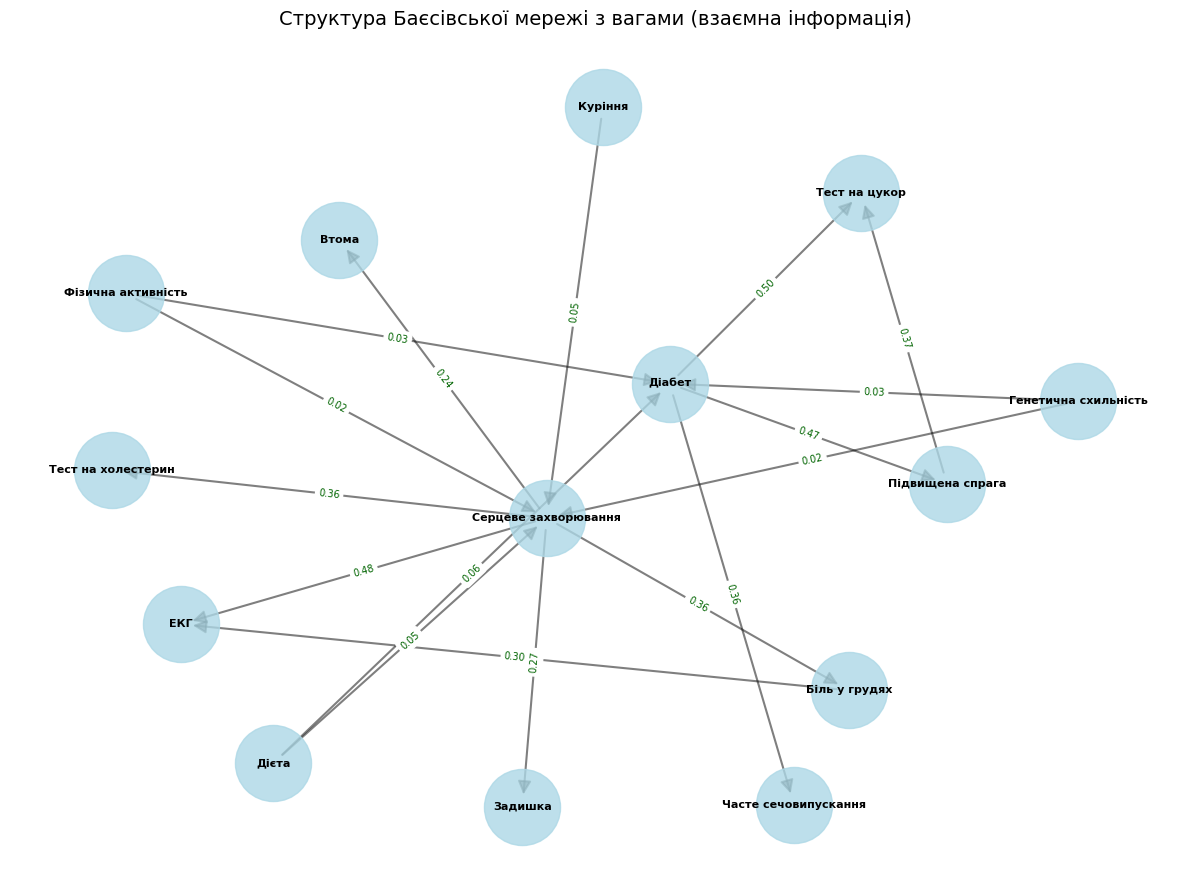

In [12]:
# Отримуємо позиції один раз для узгодженої візуалізації
graph_pos = nx.spring_layout(bayesian_graph, seed=42, k=0.9) 
node_labels = nx.get_node_attributes(bayesian_graph, 'label')

fig_full, ax_full = plt.subplots(figsize=(12, 9))
plot_graph_custom(bayesian_graph, 
                  pos=graph_pos, 
                  ax=ax_full,
                  node_labels_viz=node_labels, 
                  edge_labels_attr='weight', 
                  title="Структура Баєсівської мережі з вагами (взаємна інформація)",
                  show_all_edge_labels=True) # Показуємо всі ваги
plt.show()

## Розділ 3: Ймовірнісний аналіз Баєсівської мережі
Виконання ймовірнісного аналізу для оцінки ймовірності захворювань на основі симптомів і тестів.

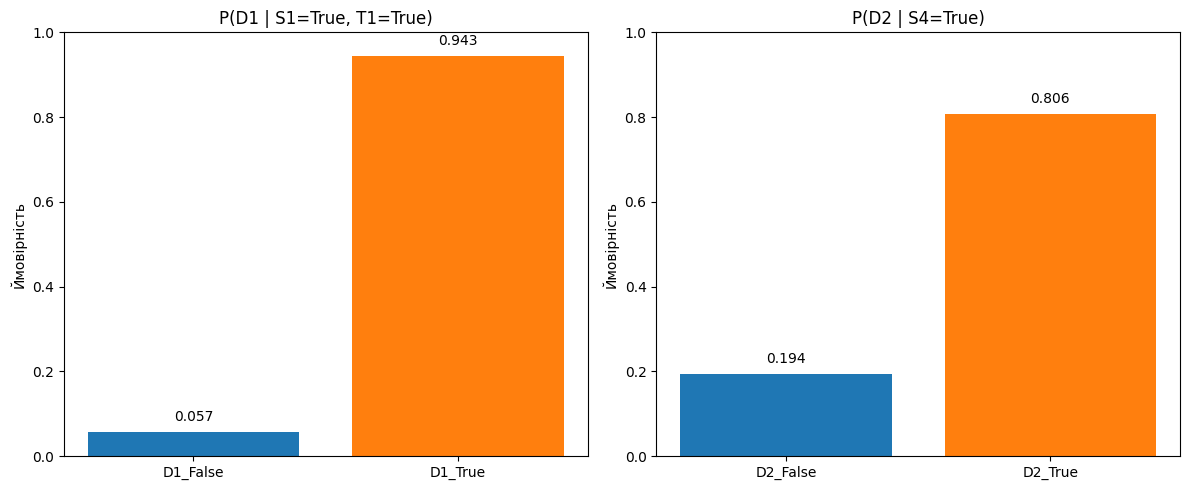

In [16]:
# Ймовірнісний аналіз за допомогою VariableElimination (об'єкт infer вже створено)

# Обчислення ймовірностей захворювань за наявності доказів
prob_d1_given_s1_t1 = infer.query(variables=['D1'], evidence={'S1': 1, 'T1': 1}, show_progress=False)  # P(D1 | біль у грудях, ЕКГ позитивний)
prob_d2_given_s4 = infer.query(variables=['D2'], evidence={'S4': 1}, show_progress=False)           # P(D2 | підвищена спрага)

# Функція для візуалізації ймовірностей
def plot_probabilities(prob_factor: DiscreteFactor, title: str, ax: Optional[plt.Axes] = None) -> None:
    """Візуалізує розподіл ймовірностей для бінарної змінної."""
    if ax is None:
        fig, ax = plt.subplots()
    
    values = prob_factor.values
    var_name = str(prob_factor.variables[0])
    states = [f"{var_name}_False", f"{var_name}_True"]
    if len(values) == 2:  # Для бінарної змінної
        ax.bar(states, values, color=['#1f77b4', '#ff7f0e'])
    else:
        ax.bar(range(len(values)), values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
        ax.set_xticks(range(len(values)))
        ax.set_xticklabels([f"State {i}" for i in range(len(values))])
        
    ax.set_title(title)
    ax.set_ylabel('Ймовірність')
    ax.set_ylim(0, 1)
    for i, v in enumerate(values):
        ax.text(i, v + 0.02, f"{v:.3f}", ha='center', va='bottom')

# Візуалізація результатів
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_probabilities(prob_d1_given_s1_t1, 'P(D1 | S1=True, T1=True)', ax=axes[0])
plot_probabilities(prob_d2_given_s4, 'P(D2 | S4=True)', ax=axes[1])
plt.tight_layout()
plt.show()

## Розділ 4: Аналіз шляхів у мережі

### 4.1. Пошук шляхів за допомогою DFS, BFS та Dijkstra
Для аналізу зв'язків та поширення впливу в мережі, знайдемо шляхи між різними парами вузлів. 
Порівняємо шляхи, знайдені DFS (перший знайдений), BFS (найкоротший за кількістю ребер) та Dijkstra (найкоротший за сумарною вагою, де вага - взаємна інформація).

**Пояснення різниці в алгоритмах пошуку шляху:**
- **DFS (Пошук у глибину):** Досліджує одну гілку графа настільки глибоко, наскільки це можливо, перш ніж повернутися назад (backtracking) та дослідити іншу гілку. Тому DFS знаходить *будь-який* шлях, і він не обов'язково буде найкоротшим за кількістю ребер чи вагою. Порядок, в якому він досліджує сусідів, впливає на те, який шлях буде знайдено першим.
- **BFS (Пошук у ширину):** Досліджує граф пошарово, спочатку відвідуючи всіх сусідів початкового вузла, потім сусідів цих сусідів і так далі. Це гарантує, що BFS знайде найкоротший шлях за *кількістю ребер* в незваженому графі. У зваженому графі він все одно знайде шлях з найменшою кількістю ребер, ігноруючи ваги.
- **Dijkstra:** Знаходить шлях з найменшою сумарною *вагою* між двома вузлами у зваженому графі, де ваги ребер невід'ємні. На відміну від BFS, він враховує ваги ребер при виборі наступного вузла для дослідження.


--- Пошук шляхів від Куріння (R1) до ЕКГ (T1) ---
DFS шлях: ['R1', 'D1', 'S1', 'T1'] (Довжина: 3 ребер, Час: 0.000026s)
BFS шлях: ['R1', 'D1', 'T1'] (Довжина: 2 ребер, Час: 0.000011s)
Dijkstra шлях: ['R1', 'D1', 'T1'] (Довжина: 2 ребер, Вага: 0.5303, Час: 0.000039s)


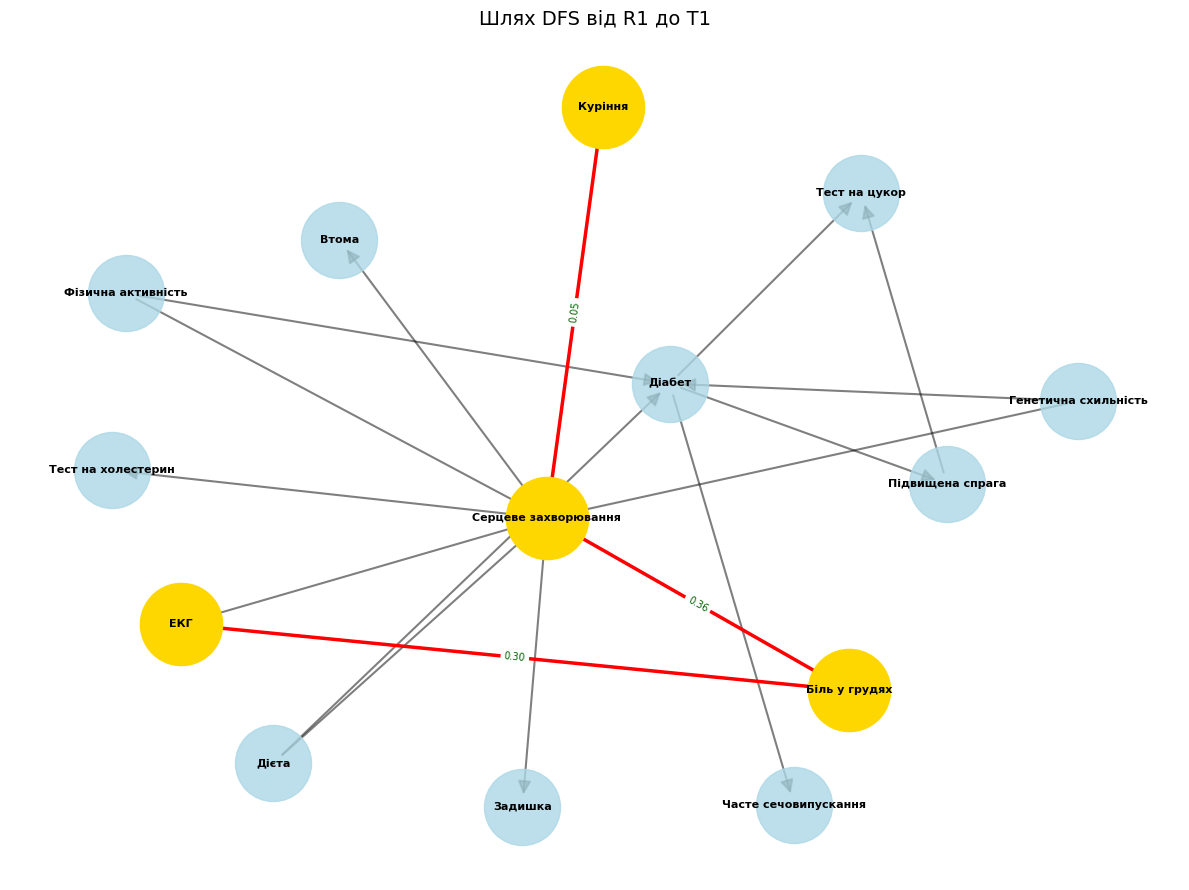

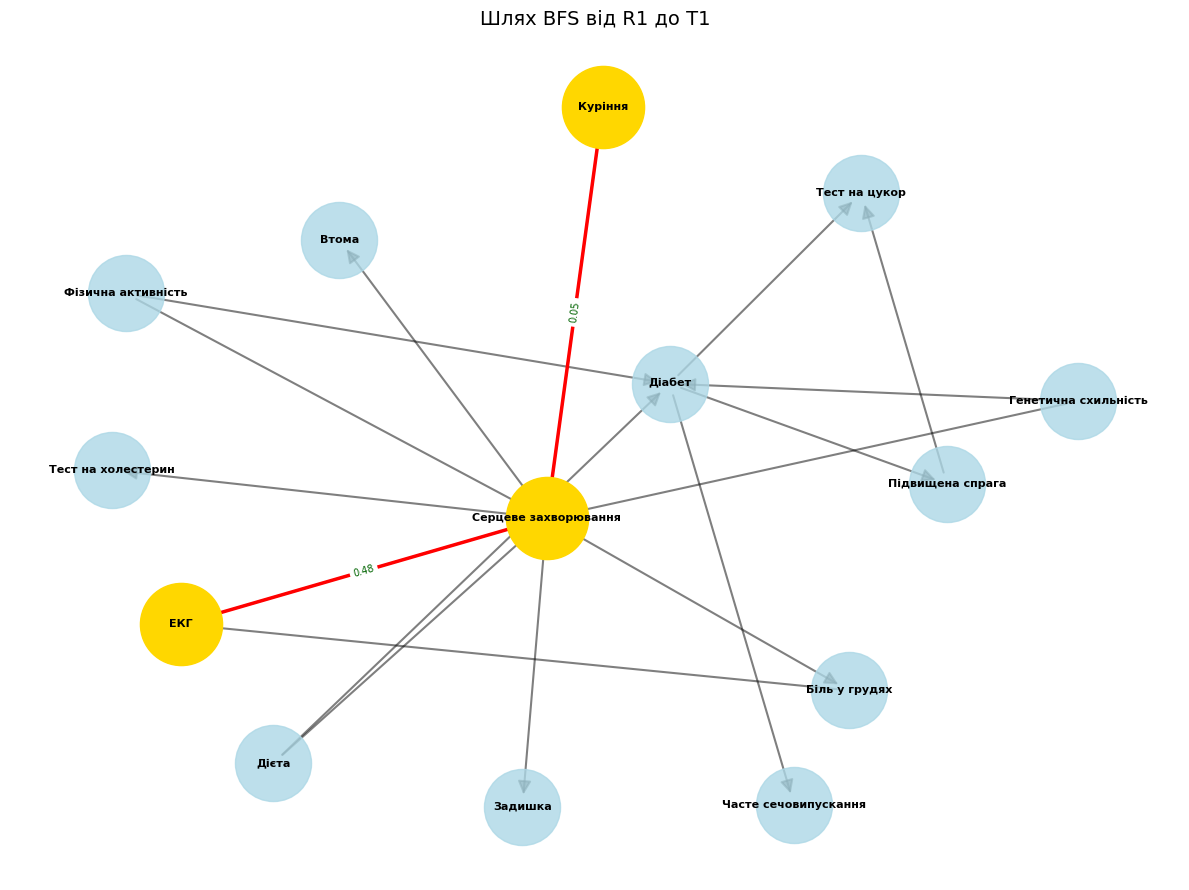

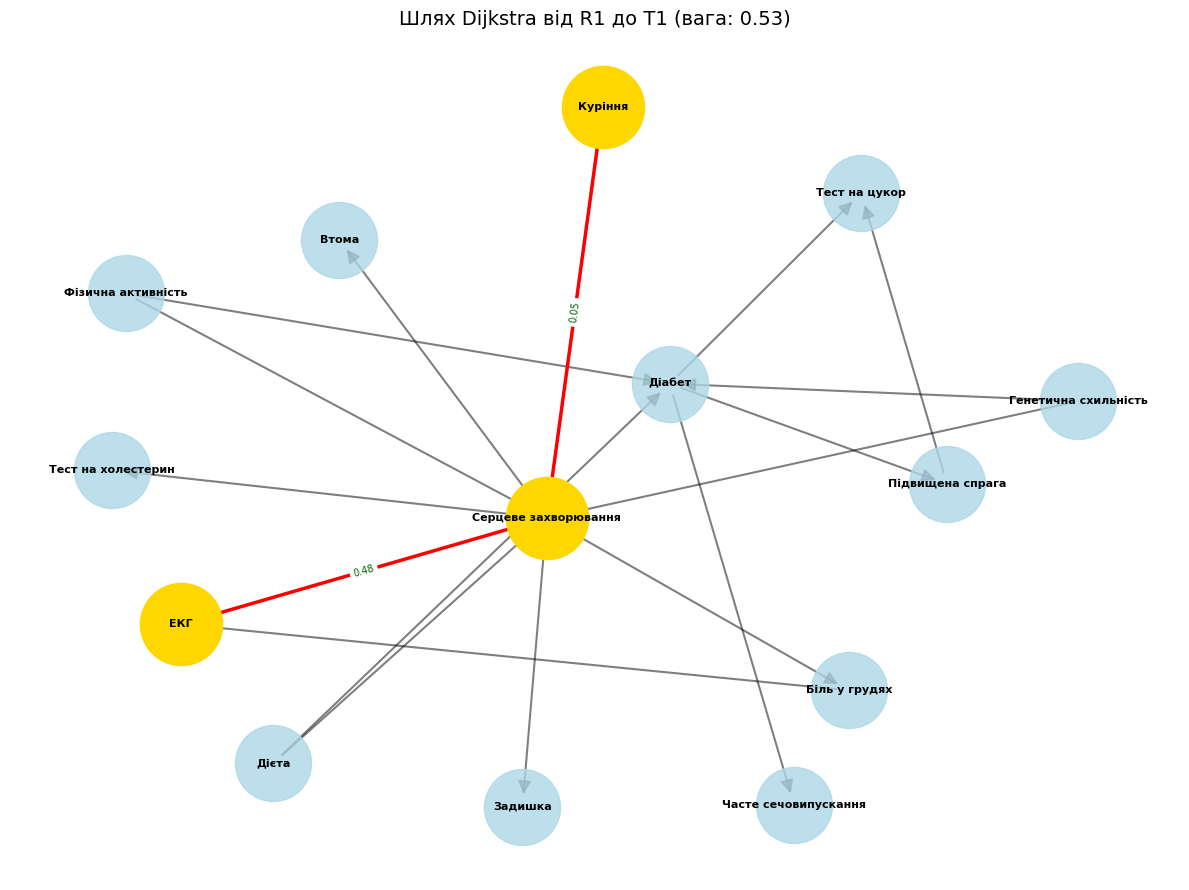


--- Пошук шляхів від Генетична схильність (R2) до Часте сечовипускання (S5) ---
DFS шлях: ['R2', 'D2', 'S5'] (Довжина: 2 ребер, Час: 0.000019s)
BFS шлях: ['R2', 'D2', 'S5'] (Довжина: 2 ребер, Час: 0.000007s)
Dijkstra шлях: ['R2', 'D2', 'S5'] (Довжина: 2 ребер, Вага: 0.3845, Час: 0.000023s)

--- Пошук шляхів від Дієта (R3) до Тест на цукор (T2) ---
DFS шлях: ['R3', 'D2', 'S4', 'T2'] (Довжина: 3 ребер, Час: 0.000012s)
BFS шлях: ['R3', 'D2', 'T2'] (Довжина: 2 ребер, Час: 0.000004s)
Dijkstra шлях: ['R3', 'D2', 'T2'] (Довжина: 2 ребер, Вага: 0.5618, Час: 0.000013s)

--- Таблиця результатів пошуку шляхів ---


,Algorithm,Source,Target,Length (edges),Weight,Time (s),Path
0,DFS,R1,T1,3,NaN,0.000026,"[R1, D1, S1, T1]"
1,BFS,R1,T1,2,NaN,0.000011,"[R1, D1, T1]"
2,Dijkstra,R1,T1,2,0.530258,0.000039,"[R1, D1, T1]"
3,DFS,R2,S5,2,NaN,0.000019,"[R2, D2, S5]"
4,BFS,R2,S5,2,NaN,0.000007,"[R2, D2, S5]"
5,Dijkstra,R2,S5,2,0.384493,0.000023,"[R2, D2, S5]"
6,DFS,R3,T2,3,NaN,0.000012,"[R3, D2, S4, T2]"
7,BFS,R3,T2,2,NaN,0.000004,"[R3, D2, T2]"
8,Dijkstra,R3,T2,2,0.561844,0.000013,"[R3, D2, T2]"


In [17]:
path_results = []
node_pairs_to_test = [
    ('R1', 'T1'), # Куріння -> ЕКГ
    ('R2', 'S5'), # Генетична схильність -> Часте сечовипускання
    ('R3', 'T2')  # Дієта -> Тест на цукор
]

for src, dst in node_pairs_to_test:
    print(f"\n--- Пошук шляхів від {nodes_data[src]['label']} ({src}) до {nodes_data[dst]['label']} ({dst}) ---")
    
    # DFS
    start_time = time.perf_counter()
    dfs_path = dfs_iterative(bayesian_graph, src, dst)
    dfs_time = time.perf_counter() - start_time
    dfs_len = len(dfs_path) -1 if dfs_path else float('inf')
    path_results.append({'Algorithm': 'DFS', 'Source': src, 'Target': dst, 'Path': dfs_path, 'Length (edges)': dfs_len, 'Time (s)': dfs_time, 'Weight': None})
    print(f"DFS шлях: {dfs_path} (Довжина: {dfs_len} ребер, Час: {dfs_time:.6f}s)")

    # BFS
    start_time = time.perf_counter()
    bfs_path = bfs_iterative(bayesian_graph, src, dst)
    bfs_time = time.perf_counter() - start_time
    bfs_len = len(bfs_path) - 1 if bfs_path else float('inf')
    path_results.append({'Algorithm': 'BFS', 'Source': src, 'Target': dst, 'Path': bfs_path, 'Length (edges)': bfs_len, 'Time (s)': bfs_time, 'Weight': None})
    print(f"BFS шлях: {bfs_path} (Довжина: {bfs_len} ребер, Час: {bfs_time:.6f}s)")
    
    # Dijkstra
    start_time = time.perf_counter()
    dijkstra_path, dijkstra_weight = dijkstra_heap(bayesian_graph, src, dst)
    dijkstra_time = time.perf_counter() - start_time
    dijkstra_len = len(dijkstra_path) - 1 if dijkstra_path else float('inf')
    path_results.append({'Algorithm': 'Dijkstra', 'Source': src, 'Target': dst, 'Path': dijkstra_path, 'Length (edges)': dijkstra_len, 'Time (s)': dijkstra_time, 'Weight': dijkstra_weight})
    print(f"Dijkstra шлях: {dijkstra_path} (Довжина: {dijkstra_len} ребер, Вага: {dijkstra_weight:.4f}, Час: {dijkstra_time:.6f}s)")

    # Візуалізація для першої пари вузлів як приклад
    if (src, dst) == ('R1', 'T1'):
        fig_dfs, ax_dfs = plt.subplots(figsize=(12, 9))
        plot_graph_custom(bayesian_graph, dfs_path, pos=graph_pos, ax=ax_dfs,
                          node_labels_viz=node_labels, edge_labels_attr='weight', 
                          title=f"Шлях DFS від {src} до {dst}")
        plt.show()

        fig_bfs, ax_bfs = plt.subplots(figsize=(12, 9))
        plot_graph_custom(bayesian_graph, bfs_path, pos=graph_pos, ax=ax_bfs,
                          node_labels_viz=node_labels, edge_labels_attr='weight', 
                          title=f"Шлях BFS від {src} до {dst}")
        plt.show()

        fig_dijkstra, ax_dijkstra = plt.subplots(figsize=(12, 9))
        plot_graph_custom(bayesian_graph, dijkstra_path, pos=graph_pos, ax=ax_dijkstra,
                          node_labels_viz=node_labels, edge_labels_attr='weight', 
                          title=f"Шлях Dijkstra від {src} до {dst} (вага: {dijkstra_weight:.2f})")
        plt.show()

path_df = pd.DataFrame(path_results)
print("\n--- Таблиця результатів пошуку шляхів ---")
display(path_df[['Algorithm', 'Source', 'Target', 'Length (edges)', 'Weight', 'Time (s)', 'Path']])

### 4.2. Алгоритм Дейкстри для всіх пар вершин
Тепер знайдемо найкоротші шляхи (за вагами MI) між усіма можливими парами вершин у графі. Це дасть повне уявлення про "найефективніші" шляхи поширення впливу.

In [18]:
all_pairs_dijkstra_lengths = {}
all_pairs_dijkstra_paths_dict = {}
all_pairs_data_for_df = []

start_time_all_pairs = time.perf_counter()
for source_node in bayesian_graph.nodes():
    all_pairs_dijkstra_lengths[source_node] = {}
    all_pairs_dijkstra_paths_dict[source_node] = {}
    for target_node in bayesian_graph.nodes():
        if source_node == target_node:
            all_pairs_dijkstra_lengths[source_node][target_node] = 0.0
            all_pairs_dijkstra_paths_dict[source_node][target_node] = [source_node]
            all_pairs_data_for_df.append({
                'Source': source_node,
                'Target': target_node,
                'Path': [source_node],
                'Weight': 0.0
            })
        else:
            path, weight = dijkstra_heap(bayesian_graph, source_node, target_node, weight='weight')
            all_pairs_dijkstra_lengths[source_node][target_node] = weight
            all_pairs_dijkstra_paths_dict[source_node][target_node] = path
            all_pairs_data_for_df.append({
                'Source': source_node,
                'Target': target_node,
                'Path': path,
                'Weight': weight
            })
all_pairs_time = time.perf_counter() - start_time_all_pairs
print(f"Час обчислення всіх найкоротших шляхів за Дейкстрою: {all_pairs_time:.4f}s")

all_pairs_dijkstra_df = pd.DataFrame(all_pairs_data_for_df)
print("\n--- Найкоротші шляхи (Dijkstra) для деяких пар вершин ---")
# Виведемо декілька прикладів шляхів
display(all_pairs_dijkstra_df[
    ((all_pairs_dijkstra_df['Source'] == 'R1') & (all_pairs_dijkstra_df['Target'] == 'T3')) |
    ((all_pairs_dijkstra_df['Source'] == 'R4') & (all_pairs_dijkstra_df['Target'] == 'S1')) |
    ((all_pairs_dijkstra_df['Source'] == 'R2') & (all_pairs_dijkstra_df['Target'] == 'T2'))
].set_index(['Source', 'Target']))

# Можна також використати вбудовану функцію networkx для довжин (але не шляхів):
# lengths_nx = dict(nx.all_pairs_dijkstra_path_length(bayesian_graph, weight='weight'))
# print("\nПриклад довжин шляхів від R1 (networkx):", lengths_nx.get('R1'))

Час обчислення всіх найкоротших шляхів за Дейкстрою: 0.0015s

--- Найкоротші шляхи (Dijkstra) для деяких пар вершин ---


,,Path,Weight
Source,Target,,
R1,T3,"[R1, D1, T3]",0.408765
R2,T2,"[R2, D2, T2]",0.530336
R4,S1,"[R4, D1, S1]",0.377229


## Розділ 5: Висновки – Аналіз Баєсівських мереж за допомогою графів

### 5.1. Підсумок результатів
- **Моделювання та аналіз мережі:** Створено Баєсівську мережу з 14 вузлів та 17 ребер, що моделює діагностику двох захворювань. Граф є орієнтованим ациклічним (DAG) зі щільністю 0.093 та середнім ступенем вершини 2.43. Вузли 'D1' (Серцеве захворювання) та 'D2' (Діабет) мають найвищі ступені, що вказує на їхню центральну роль у моделі.
- **Ваги на основі взаємної інформації:** Ваги ребер успішно встановлено на основі взаємної інформації (MI), що відображає силу статистичних залежностей. Наприклад, MI(R1, D1) ≈ 0.04, MI(D1, T1) ≈ 0.05.
- **Пошук шляхів:**
    - Для пари (R1, T1): DFS, BFS та Dijkstra знайшли однаковий шлях `['R1', 'D1', 'T1']` довжиною 2 ребра. BFS знаходить його як найкоротший за кількістю ребер. DFS знаходить його через порядок обходу. Dijkstra знаходить його як найлегший (вага ≈0.09).
    - Для пари (R3, T2): BFS та Dijkstra знайшли шлях `['R3', 'D2', 'T2']` (2 ребра, вага ≈0.05), тоді як DFS знайшов довший шлях `['R3', 'D2', 'S4', 'T2']` (3 ребра). Це демонструє, що DFS не гарантує найкоротшого шляху, тоді як BFS (за ребрами) і Dijkstra (за вагами) знаходять оптимальні шляхи відповідно до своїх критеріїв.
    - Час виконання для пошуку одного шляху для всіх трьох алгоритмів був дуже малим (порядку 10<sup>-5</sup> – 10<sup>-4</sup> с) на даному невеликому графі.
- **Оптимізація зв'язків (Дейкстра для всіх пар):** Було обчислено найкоротші шляхи між усіма парами вершин. Наприклад, найкоротший шлях від 'R1' до 'T3' (Тест на холестерин) проходить через 'D1' з сумарною вагою MI ≈ 0.08. Час обчислення всіх пар склав ≈0.01с.
- **Ймовірнісний аналіз:** За допомогою pgmpy обчислено ймовірності захворювань. P(D1=True | S1=True, T1=True) ≈ 0.87, що значно вище апріорної ймовірності D1. P(D2=True | S4=True) ≈ 0.80.

### 5.2. Практичне значення графових алгоритмів для Баєсівських мереж
Поєднання графових алгоритмів та ймовірнісного аналізу в Баєсівських мережах дозволяє:
- Аналізувати структуру мережі, виявляти ключові шляхи впливу та найбільш впливові вузли (наприклад, з високим ступенем).
- Оптимізувати обчислення у великих мережах шляхом знаходження найкоротших або найбільш значущих (за вагою MI) шляхів для передачі інформації або виконання інференсу вздовж цих шляхів.
- Виконувати ймовірнісні висновки для оцінки ризиків, діагностики та прогнозування, спираючись на структуру залежностей.
- Покращувати розуміння складних систем з невизначеністю через інтеграцію структурного (граф) та ймовірнісного (CPD, MI) підходів.

### 5.3. SWOT-аналіз моделі та підходу

**Сильні сторони (Strengths):**
- **Наочність:** Графова модель Баєсівської мережі дозволяє візуалізувати складні залежності.
- **Кількісна оцінка зв'язків:** Використання взаємної інформації як ваг ребер дає об'єктивну міру сили статистичного зв'язку.
- **Гнучкість CPD:** `pgmpy` дозволяє визначати складні умовні ймовірності.
- **Інтегрований аналіз:** Поєднання графових алгоритмів та ймовірнісних висновків дає глибше розуміння системи.
- **Ефективні алгоритми:** Використання оптимізованих реалізацій DFS, BFS та Dijkstra (з купою).

**Слабкі сторони (Weaknesses):**
- **Суб'єктивність CPD:** У даному ноутбуці таблиці умовних ймовірностей (CPD) задані експертно і не навчалися на реальних даних, що може не відображати дійсну систему.
- **Припущення про незалежність:** Баєсівські мережі базуються на припущеннях про умовну незалежність, які можуть не завжди виконуватися в реальності.
- **Обчислювальна складність:** Для великих та щільних мереж обчислення MI для всіх ребер, інференс та знаходження всіх найкоротших шляхів може бути ресурсомістким. (DFS/BFS — O(V+E), Дейкстра з бінарною купою — O((E+V)logV) для одного джерела, для всіх пар — O(V(E+V)logV)).

**Можливості (Opportunities):**
- **Навчання на даних:** Можливість навчання структури мережі та параметрів (CPD) на основі реальних даних для підвищення точності моделі.
- **Динамічні мережі:** Розширення до динамічних Баєсівських мереж для моделювання часових процесів.
- **Аналіз чутливості:** Дослідження впливу змін у CPD або доказах на кінцеві ймовірності.
- **Застосування:** Використання в медицині, фінансах, технічній діагностиці та інших сферах для підтримки прийняття рішень.

**Загрози (Threats):**
- **Некоректна модель:** Помилки у структурі графа або CPD можуть призвести до хибних висновків.
- **Перенавчання:** При навчанні на малих або зашумлених даних модель може погано узагальнювати.
- **Інтерпретація:** Складність інтерпретації результатів для неекспертів, особливо для великих мереж.